# Solving a Laplace problem with Dirichlet boundary conditions

### Background

- Laplace problem inside the unit sphere with Dirichlet boundary conditions. Let $\Omega$ be the unit sphere with boundary $\Gamma$. Let $\nu$ be the outward pointing normal on $\Gamma$. The PDE and boundary conditions are given by

\begin{align}
\Delta u &= 0&&\text{in }\Omega,\\
u &= f&&\text{on }\Gamma.
\end{align}

The boundary data is a source $\hat{u}$ located at the point $(0.9,0,0)$.
$$
\hat{u}(\mathbf x)=\frac{1}{4\pi\sqrt{(x-0.9)^2+y^2+z^2}}.
$$

For this example, we will use a direct integral equation of the first kind. Let
$$
g(\mathbf x,\mathbf y) = \frac{1}{4\pi |\mathbf x-\mathbf y|}
$$
be the Green's function for Laplace in three dimensions. From Green's representation theorem, it follows that every harmonic function $u$ in $\Omega$ satisfies

$$
u(\mathbf x) = \int_{\Gamma} g(\mathbf x,\mathbf y)\frac{\partial u(\mathbf y)}{\partial \nu(\mathbf{y})}\mathrm{d}\mathbf y-\int_{\Gamma}\frac{\partial g(\mathbf x,\mathbf y)}{\partial \nu(\mathbf{y})}u(\mathbf y)\mathrm{d}\mathbf y,~\mathbf x\in\Omega\setminus\Gamma
$$

or equivalantly

$$
u(\mathbf x) = \left[\mathcal{V}\frac{\partial u(\mathbf y)}{\partial \nu(\mathbf{y})}\right] (\mathbf{x}) - \left[\mathcal{K}u\right] (\mathbf{x}),~\mathbf x\in\Omega\setminus\Gamma,
$$

where $\mathcal{V}$ and $\mathcal{K}$ are the <a href='https://bempp.com/2017/07/11/available_operators/'>single and double layer potential operators</a>.

Taking the limit $\mathbf x\rightarrow \Gamma$ we obtain the boundary integral equation

$$
\left[\mathsf{V}\frac{\partial u}{\partial n}\right] (\mathbf x)=\left[(\tfrac12\mathsf{Id}+\mathsf{K})u\right] (\mathbf x),~\mathbf x\in\Gamma.
$$

Here, $\mathsf{V}$ and $\mathsf{K}$ are the <a href='https://bempp.com/2017/07/11/available_operators/'>single and double layer boundary operators</a>. 

This equation is the target equation that we will solve with respect to unknown norrmal derivative on the boundary $\frac{\partial u}{\partial n}$.

When we get normal derivative on the boundary 
$$
\frac{\partial u}{\partial n}
$$
we can use Green representation theorem to compute $u(x)$ in any points inside the domain $\Omega$.

### Implementation

We now demonstrate how to solve this problem with Bempp. We begin by importing Bempp and NumPy.

In [6]:
import bempp.api
import numpy as np

We next define a mesh or grid. For this problem, we will use the built-in function `sphere` that defines a simple spherical grid. Details of other available grids can be found in the <a href='https://bempp.com/2017/07/06/grids-in-bempp'>grids tutorial</a>.

In [7]:
grid = bempp.api.shapes.sphere(h=0.1)

We now define the <a href='https://bempp.com/2017/07/11/function-spaces/'>spaces</a>. 
We will use two spaces: 
- the space of continuous, piecewise linear functions
- the space of piecewise constant functions. 

The space of piecewise constant functions has the right smoothness for the unknown Neumann data. 
We will use continuous, piecewise linear functions to represent the known Dirichlet data.

In [8]:
dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

We can now define the <a href='https://bempp.com/2017/07/11/operators/'>operators</a>. We need the identity, single layer, and double layer boundary operator.

In [9]:
identity = bempp.api.operators.boundary.sparse.identity(
    p1_space, p1_space, dp0_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    p1_space, p1_space, dp0_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)

We now define the <a href='https://bempp.com/2017/07/11/grid-functions/'>GridFunction object</a> on the sphere grid that represents the Dirichlet data.

In [10]:
def dirichlet_data(x, n, domain_index, result):
    result[0] = 1./(4 * np.pi * ((x[0] - .9)**2 + x[1]**2 + x[2]**2)**(0.5))
    
dirichlet_fun = bempp.api.GridFunction(p1_space, fun=dirichlet_data)

We next assemble the right-hand side of the boundary integral equation, given by 
$$
(\tfrac12\mathsf{Id}+\mathsf{K})u.
$$

We use implemented operators algebra to define right-hand side.

In [11]:
rhs = (.5 * identity + dlp) * dirichlet_fun

We now <a href='https://bempp.com/2017/07/12/solving-linear-systems/'>solve the linear system</a> using a conjugate gradient (CG) method.

In [12]:
neumann_fun, info = bempp.api.linalg.cg(slp, rhs, tol=1E-3)

We now want to provide a simple plot of the solution in the $(x,y)$ plane for $z=0$. We first define points at which to plot the solution.

In [13]:
n_grid_points = 150
plot_grid = np.mgrid[-1:1:n_grid_points*1j, -1:1:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

The variable `points` now contains in its columns the coordinates of the evaluation points. We can now use Green's representation theorem to evaluate the solution on these points. Note in particular the last line of the following code. It is a direct implementation of Green's representation theorem.

In [14]:
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

We now plot the 2D slice of the solution. For a full three dimensional visualization, Bempp can <a href='https://bempp.com/2017/07/12/import-and-export-of-gmsh-files/'>export the data to Gmsh</a>. Since the solution decays quickly, we use a logarithmic plot.

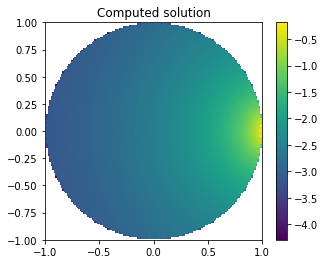

In [16]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0)
from matplotlib import pylab as plt

# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points, n_grid_points))
radius = np.sqrt(plot_grid[0]**2 + plot_grid[1]**2)
u_evaluated[radius>1] = np.nan

plt.imshow(np.log(np.abs(u_evaluated.T)), extent=(-1,1,-1,1))
plt.title('Computed solution')
plt.colorbar()